In [3]:
from math import ceil, floor, pi, log2
import numpy as np
from matplotlib import pyplot as plt

import ffmpegio as ff

from straight_pitch.utils import decimate
from straight_pitch.straight_pitch import (
    zinitializeParameters,
    cleaninglownoise_filter,
    cleaninglownoise,
)
from straight_pitch.fixpF0VexMltpBG4 import (
    zwvlt2ifq,
    zsmoothmapB,
    zifq2gpm2,
    zfixpfreq3,
    znrmlcf2,
)

two_pi = 2 * pi

### Load sample audio at 16 kS/s and perform the initial fixed-point analysis

In [8]:
from straight_pitch.fixpF0VexMltpBG4 import fixpF0VexMltpBG4
from straight_pitch.straight_pitch import (
    zinitializeParameters,
    zplotcpower,
    cleaninglownoise,
)

fs, xin = ff.audio.read("../test/vaiueo2d.wav", sample_fmt="dbl", ac=1, ar=16000)

xin = xin[:, 0]  # make it 1D

prm = zinitializeParameters()

# f0 search channels
f0floor = prm["F0searchLowerBound"]
f0ceil = prm["F0searchUpperBound"]
nvo = prm["NofChannelsInOctave"]
nvc = ceil(log2(f0ceil / f0floor) * nvo)  # number of channels
Fxx = f0floor * 2 ** (np.arange(nvc) / nvo)  # channel center frequencies in Hz

# remove the low-frequency noise
x = cleaninglownoise(xin, fs, f0floor)

# ---- F0 extraction based on a fixed-point method via filterbank
f0v, vrv, dfv, aav, frame_step = fixpF0VexMltpBG4(
    x,
    Fxx / fs,
    prm["IFWindowStretch"],
    round(prm["F0frameUpdateInterval"] * 1e-3 * fs),
    prm["IFsmoothingLengthRelToFc"],
    round(prm["IFminimumSmoothingLength"] * 1e-3 * fs),
    prm["IFexponentForNonlinearSum"],
    prm["IFnumberOfHarmonicForInitialEstimate"],
)

flp: float = 125
fhp: float = 3000
htr, pw, pwt = zplotcpower(x, flp / fs, fhp / fs, frame_step)

# Fixed point analysis of instantaneous fundamental frequency

Load the relevant STRAIGHT parameters:

C:\Users\Takeshi Ikuma\AppData\Local\Temp\ipykernel_8124\1369226347.py:28: RuntimeWarning: invalid value encountered in divide
  plt.plot(vrv_sorted[:, 0] / vrv_sorted[:, 1],'.-')


(252.0, 352.0)

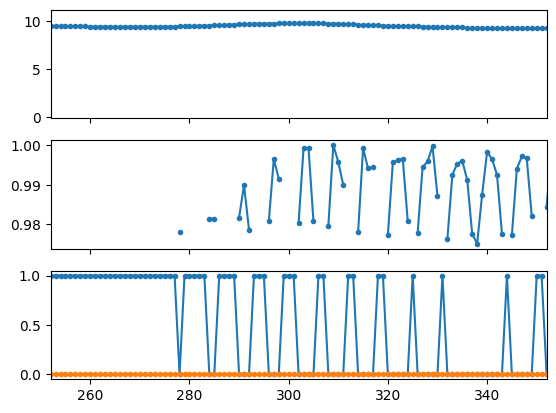

In [67]:
thf0j: float = (
    0.04  #  f0 change wrt next/prev frame, f0_current/abs(f0_current-f0_neighbor) < thf0j => voiced
)
hth: float = 0.05  # high-conf threshold on vrv < hth => voiced
lth: float = 0.9  # low-conf threshold on vrv < lth => voiced
dhth: float = 0.975  # 2nd-min vrv / min vrv > dhth => voiced
htrth: float = 0.02  # threshold on htr  < htrth => voiced
bklm: int = 100  # back track length for voicing decision
lalm: int = 10  # look ahead length for silence decision

# first select the highest confidence voiced frames by low vrv, lone low vrv, low htr
cn_ok_cands = vrv < hth
cn_ok = (cn_ok_cands).any(axis=1)

vrv[np.isnan(vrv)] = np.inf
vrv_sorted = np.sort(vrv, axis=1)

multi_tones = vrv_sorted[:, 0] / vrv_sorted[:, 1] < dhth

vrv_min = vrv_sorted[:,0]
vrv_min[multi_tones] = np.inf
n0 = np.argmin(vrv_sorted[:,0])

plt.subplots(3,1,sharex=True)
plt.subplot(3,1,1)
plt.plot(1/np.nanmin(vrv,axis=1),'.-')
plt.subplot(3,1,2)
plt.plot(vrv_sorted[:, 0] / vrv_sorted[:, 1],'.-')
plt.subplot(3,1,3)
plt.plot(multi_tones,'.-')
plt.plot(cn_ok,'.-')
plt.xlim(n0-50,n0+50)

# f0 = np.zeros_like(voiced,float)
# status = np.zeros_like(voiced,int)
# status[voiced] = 1
# status[unvoiced] = -1
# iunkown = np.where(~status)[0]

# for i in np.where(voiced)[0]:
#     f0[i] = f0v[i,np.nanargmin(vrv[i])]

# plt.plot(f0*fs,'.-')

In [69]:
# now iterate forward and backward until a close f0 cannot be found
nb_frames = len(f0v)
f0 = np.zeros_like(nb_frames, float)
status = np.zeros_like(nb_frames, int)

status[n0] = 1
f0[n0] = f0v[np.nanargmin(vrv[n0])]
for n in np.arange(n0, nb_frames):
    print(vrv[n])
    break

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

In [ ]:

pwr_ok = htr < htrth
no_f0 = np.isnan(f0v).all(axis=1)

t = np.arange(len(x)) / frame_step

plt.subplots(5, 1, figsize=[16, 6], sharex=True)
plt.subplot(5, 1, 1)
plt.plot(t, x)
plt.ylabel("signal")
plt.subplot(5, 1, 2)
plt.plot(1/np.nanmin(vrv,axis=1))
plt.ylabel("min vrv")
plt.plot(cn_ok)
plt.ylabel("C/N on")
plt.subplot(4, 1, 3)
plt.plot(pwr_ok)
plt.ylabel("power on")
plt.subplot(4, 1, 4)
plt.plot(no_f0)
plt.ylabel("no f0");

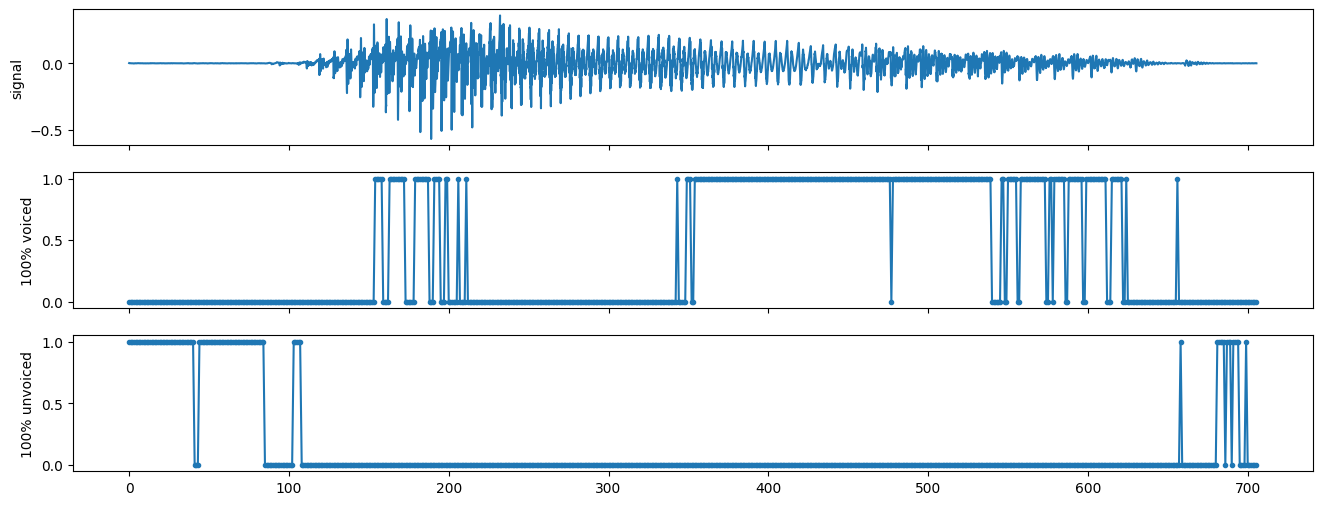

In [29]:
# if no candidate, 100% not voiced
unvoiced = no_f0 | ~(cn_ok | pwr_ok)  # true if 100% unvoiced
voiced = ~no_f0 & cn_ok & pwr_ok  # true if 100% voiced

t = np.arange(len(x)) / frame_step

plt.subplots(3, 1, figsize=[16, 6], sharex=True)
plt.subplot(3, 1, 1)
plt.plot(t, x)
plt.ylabel("signal")
plt.subplot(3, 1, 2)
plt.plot(voiced,'.-')
plt.ylabel("100% voiced")
plt.subplot(3, 1, 3)
plt.plot(unvoiced,'.-')
plt.ylabel("100% unvoiced");


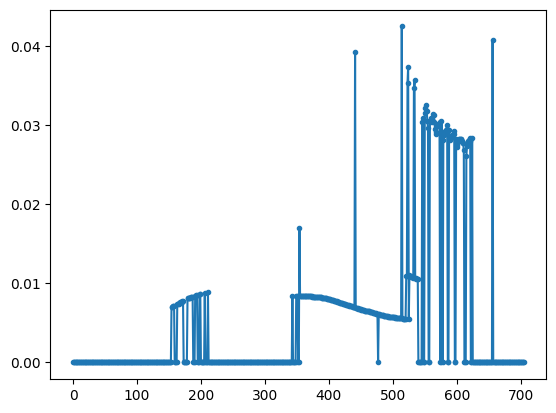

In [37]:
status[voiced] = 1
status[unvoiced] = -1
iunkown = np.where(~status)[0]

for i in np.where(voiced)[0]:
    f0[i] = f0v[i,np.nanargmin(vrv[i])]

plt.plot(f0,'.-')